## Import Libraries

In [4]:
# importing the necessary modules
import requests
from bs4 import BeautifulSoup
from zipfile import ZipFile
from io import BytesIO
import pandas as pd
import os
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from pandasql import sqldf
import pandasql as psql
import missingno as msno
from scipy import stats
from scipy.stats import pearsonr
sns.set(color_codes=True)
import statsmodels.api as sm  
from statsmodels.formula.api import ols
from sklearn import linear_model
from sklearn.datasets import load_iris

In [5]:
# Abbeviations and Details of Column Names
#Agency AGYSUB TEXT
#Location LOC TEXT
#Age AGELVL TEXT
#Education Level EDLVL TEXT
#General Schedule & Equivalent Grade GSEGRD TEXT
#Length of Service LOSLVL TEXT
#Occupation OCC TEXT
#Occupation Category PATCO TEXT
#Pay Plan & Grade PPGRD TEXT
#Salary Level SALLVL TEXT
#STEM Occupations STEMOCC TEXT
#Supervisory Status SUPERVIS TEXT
#Type Appointment TOA TEXT
#Work Schedule WORKSCH TEXT
#Work Status WORKSTAT TEXT
#Date (e.g. 202109) DATECODE TEXT
#Employment EMPLOYMENT NUMERIC
#Average Salary SALARY NUMERIC
#Average Length of Service LOS NUMERIC

## Data Import

In [6]:
#Set variable for page to be opened and url to be concatenated 
page =requests.get('https://www.opm.gov/data/index.aspx')
baseurl= 'https://www.opm.gov/'
#Use BeautifulSoup to clean up the page
soup = BeautifulSoup(page.text, "html.parser")
soup.prettify()

# Creating a new file to store the zip file links
newfile = open('zipfiles.txt','w')
#Find all the links on the page that end in .zip and write them into the text file
for anchor in soup.findAll('a', href=True):
    links = anchor['href']
    if links.endswith('.zip'):
        newfile.write(links + '\n')
newfile.close()

## Automate zipfile download and extract

In [8]:
#Fetching the links for the zip file and downloading the files
with open('zipfiles.txt', 'r') as links:
    count = 0
    for link in links:
        if count == 2:
            break
        if link:
            filename1= link.split('/')[-1]
            filename= filename1[:-1]
            link = baseurl + link
            print(filename + ' file started to download')
            response = requests.get(link[:-1])
            
            # Writing the zip file into local file system
            with open(filename,'wb') as output_file:
                output_file.write(response.content)
            print(filename + ' file is downloaded')
            with ZipFile(filename, 'r') as zip:
                # printing all the contents of the zip file
                #zip.printdir()
                print('')
            z = ZipFile(BytesIO(response.content))
            # gets September data
            if count == 0:
                def new_directory(directory, filename):
                  # Before creating a new directory, check to see if it already exists
                  if os.path.isdir(directory) == False:
                    os.mkdir(directory)
                #print(directory+" "+filename)
                z.extractall('SepData')
                print('September data Extracted')
                print('-------------------------------------------------------------')
            # gets June data    
            elif count == 1:
                def new_directory(directory, filename):
                  # Before creating a new directory, check to see if it already exists
                  if os.path.isdir(directory) == False:
                    os.mkdir('JunData')
                z.extractall('JunData')
                print('June data Extracted')
            count += 1
            

5f8e430d-fb84-4856-a25b-81f6dcc0eb7f.zip file started to download
5f8e430d-fb84-4856-a25b-81f6dcc0eb7f.zip file is downloaded

September data Extracted
-------------------------------------------------------------
9a772b04-cab4-4b89-b62a-a3859371cb13.zip file started to download
9a772b04-cab4-4b89-b62a-a3859371cb13.zip file is downloaded

June data Extracted


### Merge the datasets

In [9]:
# Importing September data using pandas
FACTDATA_S = pd.read_csv("/Users/tejaswidodda/Documents/GMU/Spring 2022/DAEN 690/Jupyter_Code/SeptData/FACTDATA_SEP2021.txt")
# Importing June data using pandas
FACTDATA_J = pd.read_csv("/Users/tejaswidodda/Documents/GMU/Spring 2022/DAEN 690/Jupyter_Code/JuneData/FACTDATA_JUN2021.txt")
#merge data of both Sep and June using pandas
data = pd.concat([FACTDATA_S, FACTDATA_J], axis=0)
data.head()

/Users/tejaswidodda/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (3,4,6,8,12,13) have mixed types. Specify dtype option on import or set low_memory=False.



,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,SALLVL,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS
0,AA00,11,F,13,NaN,F,0340,2,ES,ES-**,S,XXXX,2,50,F,1,202109,1,192500.0,18.3
1,AA00,11,I,15,NaN,H,0905,1,ES,ES-**,R,XXXX,2,50,F,1,202109,1,187000.0,28.7
2,AA00,11,E,15,15,E,0905,1,99,GS-15,Q,XXXX,2,30,F,1,202109,1,172500.0,12.0
3,AA00,11,E,15,15,E,0905,1,99,GS-15,N,XXXX,8,30,F,1,202109,1,144128.0,10.0
4,AA00,11,F,15,13,E,0905,1,99,GS-13,K,XXXX,8,30,F,1,202109,1,114059.0,12.9


# Data Cleaning

In [10]:
# Finding the type of each variable in the dataset
#data.dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4379934 entries, 0 to 2188922
Data columns (total 20 columns):
AGYSUB        object
LOC           object
AGELVL        object
EDLVL         object
GSEGRD        object
LOSLVL        object
OCC           object
PATCO         int64
PP            object
PPGRD         object
SALLVL        object
STEMOCC       object
SUPERVIS      object
TOA           object
WORKSCH       object
WORKSTAT      int64
DATECODE      int64
EMPLOYMENT    int64
SALARY        float64
LOS           float64
dtypes: float64(2), int64(4), object(14)
memory usage: 701.7+ MB


### Missing Values

In [11]:
# Sum of null values in each Attribute
#data.isnull().sum()

#Missing data in % values
data.isnull().sum()/(len(data))*100

AGYSUB         0.000000
LOC            0.000000
AGELVL         0.000000
EDLVL          0.216464
GSEGRD        29.266879
LOSLVL         0.000000
OCC            0.000000
PATCO          0.000000
PP             0.000000
PPGRD          0.000000
SALLVL         0.000000
STEMOCC        0.000000
SUPERVIS       0.000000
TOA            0.000000
WORKSCH        0.000000
WORKSTAT       0.000000
DATECODE       0.000000
EMPLOYMENT     0.000000
SALARY        13.435294
LOS            0.000845
dtype: float64

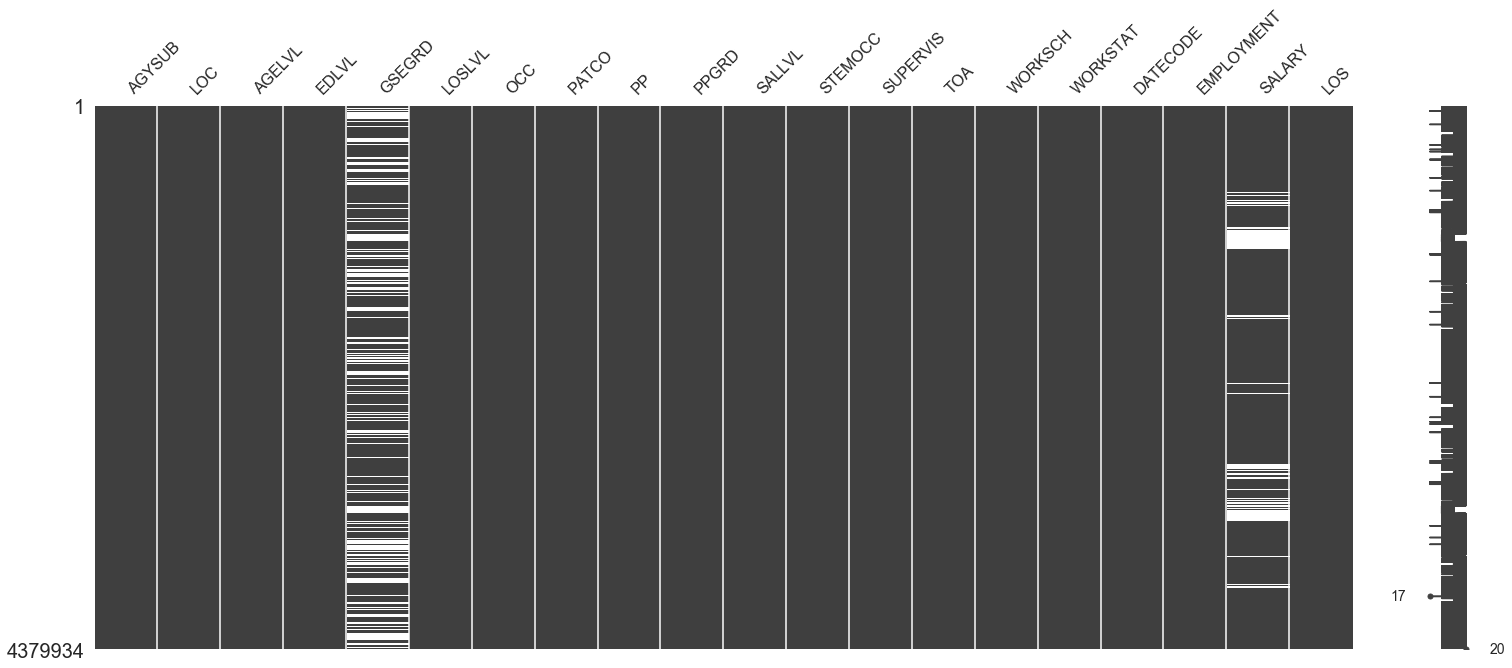

In [12]:
#Distribution of missing data
msno.matrix(data)

### Find null values grouped by agency (No Hard coding)

In [13]:
# Find null values grouped by agency
dflist1 = data.columns
# creating a new column with sum of null values in each row
dn = data.groupby(['AGYSUB'])[dflist1].apply(lambda x: x.isnull().sum())
dn['results'] = dn.sum(axis = 1)
dn.head()

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,...,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS,results
AGYSUB,,,,,,,,,,,,,,,,,,,,,
AA00,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
AB00,0,0,0,0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
AF02,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,20,0,22
AF03,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,8
AF06,0,0,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,7


## List of Agencies with zero null values (No Hard coding)

In [14]:
# Finding agencies that has zero missing values
dzero = dn[dn['results'] == 0]
dzero.iloc[: , 1:-1] #trim first and last columns of the dataframe 1=AGYSUB, -1=results
# Fetching only the agencies with zero null values
zero_NA_agy = dzero.iloc[:,0]
less_na_agy = zero_NA_agy.keys().tolist()
#less_na_agy
# verifying the zero null agencies with main data agencies and printing all columns
data_na_agy = data[data['AGYSUB'].isin(less_na_agy)]
data_na_agy

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,SALLVL,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS
38686,AF0U,24,K,08,13,D,2210,2,99,GG-13,L,2210,8,38,F,1,202109,1,127885.0,8.4
134010,AF1Q,40,J,10,13,G,1670,2,99,GS-13,K,XXXX,8,10,F,1,202109,1,116715.0,20.4
134011,AF1Q,40,E,13,12,E,0560,2,99,GS-12,I,XXXX,8,10,F,1,202109,1,92988.0,14.3
134012,AF1Q,40,K,04,13,J,2152,2,99,GS-13,L,XXXX,8,10,F,1,202109,1,129136.0,37.3
134013,AF1Q,40,I,04,12,F,1670,2,99,GS-12,I,XXXX,8,10,F,1,202109,1,98155.0,17.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1779178,VAKB,11,D,17,11,B,343,2,99,GS-11,G,XXXX,8,15,F,1,202106,1,72750.0,1.7
1779179,VAKB,11,D,17,11,B,343,2,99,GS-11,G,XXXX,8,15,F,1,202106,1,72750.0,1.3
1779180,VAKB,11,E,13,12,A,301,2,99,GS-12,H,XXXX,8,15,F,1,202106,1,87198.0,0.8
1779181,VAKB,11,E,17,11,A,301,2,99,GS-11,G,XXXX,8,20,F,2,202106,1,72750.0,0.8


## Count of records in Agencies in Ascending Order

In [15]:
# No. of records in each agency in ascending order
data_na_agy['AGYSUB'].value_counts(ascending=True).reset_index(name='Count')

,index,Count
0,HE31,2
1,AF0U,2
2,HUXX,6
3,HUKA,10
4,VAGE,14
5,HW00,24
6,EDET,30
7,HUUU,33
8,VA**,36
9,VABD,37


## Comparing both Dataframes

In [16]:
#Verify if data from both timeframes has same amount of rows
data_na_agy.groupby(['DATECODE']).count()

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,SALLVL,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,EMPLOYMENT,SALARY,LOS
DATECODE,,,,,,,,,,,,,,,,,,,
202106,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294,4294
202109,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533,4533


In [20]:
#Splitting the cleaned data for further analysis
data_na_agy_J, data_na_agy_S  = [x for _, x in data_na_agy.groupby(data_na_agy['DATECODE'])]
#data_na_agy_J.head()
#data_na_agy_S.head()

## Re-Identification

In [21]:
#adding data to sqldf's
juneDf1 = psql.sqldf("select * from data_na_agy_J where DATECODE = 202106")
septDf1 = psql.sqldf("select * from data_na_agy_S where DATECODE = 202109")

In [22]:
#Identical Employees with same LOSLVL
identical = psql.sqldf("""select 
                    j.[AGYSUB], j.[SALLVL], j.[LOSLVL], j.[DATECODE], j.[SALARY], j.[LOS], 
                    s.[AGYSUB], s.[SALLVL], s.[LOSLVL], s.[DATECODE], s.[SALARY], s.[LOS] 
                    from  
                       juneDf1 j inner join septDf1 s 
                       on j.LOS+0.3 = s.LOS and 
                       j.SALARY <= s.SALARY and j.AGYSUB = s.AGYSUB and j.LOC = s.LOC 
                       and j.AGELVL = s.AGELVL and j.EDLVL = s.EDLVL and j.PATCO = s.PATCO 
                       and j.WORKSTAT = s.WORKSTAT and j.STEMOCC = s.STEMOCC and 
                       j.SUPERVIS =s.SUPERVIS and j.TOA = s.TOA and j.LOSLVL =s.LOSLVL; """)



identical

,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS
0,AF1Q,I,F,202106,98155.0,17.3,AF1Q,I,F,202109,98155.0,17.6
1,AF1Q,K,I,202106,119787.0,32.0,AF1Q,K,I,202109,119787.0,32.3
2,AF1Q,K,G,202106,119787.0,20.4,AF1Q,K,G,202109,119787.0,20.7
3,AF1Q,K,H,202106,119787.0,26.0,AF1Q,K,H,202109,119787.0,26.3
4,AF1Q,H,E,202106,82655.0,14.5,AF1Q,H,E,202109,82655.0,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
1275,VAKB,Q,I,202106,172500.0,30.0,VAKB,Q,I,202109,172500.0,30.3
1276,VAKB,N,G,202106,148932.0,20.9,VAKB,N,G,202109,148932.0,21.2
1277,VAKB,L,D,202106,126614.0,9.0,VAKB,M,D,202109,130698.0,9.3
1278,VAKB,H,E,202106,87198.0,11.5,VAKB,J,E,202109,103690.0,11.8


In [23]:
#Employees with Salary Hike and same LOSLVL
hike = psql.sqldf("""select 
                    j.[AGYSUB], j.[SALLVL], j.[LOSLVL], j.[DATECODE], j.[SALARY], j.[LOS], 
                    s.[AGYSUB], s.[SALLVL], s.[LOSLVL], s.[DATECODE], s.[SALARY], s.[LOS] 
                    from  
                       juneDf1 j inner join septDf1 s 
                       on j.LOS+0.3 = s.LOS and 
                       j.SALARY < s.SALARY and j.AGYSUB = s.AGYSUB and j.LOC = s.LOC 
                       and j.AGELVL = s.AGELVL and j.EDLVL = s.EDLVL and j.PATCO = s.PATCO 
                       and j.WORKSTAT = s.WORKSTAT and j.STEMOCC = s.STEMOCC and 
                       j.SUPERVIS =s.SUPERVIS and j.TOA = s.TOA and j.LOSLVL =s.LOSLVL; """)



hike




,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS
0,AF1Q,N,H,202106,140859.0,27.0,AF1Q,N,H,202109,144771.0,27.3
1,AF1Q,I,D,202106,98286.0,6.8,AF1Q,J,D,202109,101358.0,7.1
2,AF20,K,H,202106,119787.0,27.9,AF20,L,H,202109,127031.0,28.2
3,AF2F,L,E,202106,120972.0,11.5,AF2F,L,E,202109,124428.0,11.8
4,AF2H,L,B,202106,122530.0,1.0,AF2H,L,B,202109,126614.0,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...
254,VAKB,M,H,202106,134782.0,28.4,VAKB,M,H,202109,138866.0,28.7
255,VAKB,N,F,202106,142950.0,17.5,VAKB,N,F,202109,147034.0,17.8
256,VAKB,L,D,202106,126614.0,9.0,VAKB,M,D,202109,130698.0,9.3
257,VAKB,H,E,202106,87198.0,11.5,VAKB,J,E,202109,103690.0,11.8


In [24]:
#Employees with no hike and with 0.3 LOS
nohike = psql.sqldf("""select 
                    j.[AGYSUB], j.[SALLVL], j.[LOSLVL], j.[DATECODE], j.[SALARY], j.[LOS], 
                    s.[AGYSUB], s.[SALLVL], s.[LOSLVL], s.[DATECODE], s.[SALARY], s.[LOS] 
                    from  
                       juneDf1 j inner join septDf1 s 
                       on j.LOS+0.3 = s.LOS and 
                       j.SALARY = s.SALARY and j.AGYSUB = s.AGYSUB and j.LOC = s.LOC 
                       and j.AGELVL = s.AGELVL and j.EDLVL = s.EDLVL and j.PATCO = s.PATCO 
                       and j.WORKSTAT = s.WORKSTAT and j.STEMOCC = s.STEMOCC and 
                       j.SUPERVIS =s.SUPERVIS and j.TOA = s.TOA and j.LOSLVL =s.LOSLVL; """)



nohike





,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS,AGYSUB,SALLVL,LOSLVL,DATECODE,SALARY,LOS
0,AF1Q,I,F,202106,98155.0,17.3,AF1Q,I,F,202109,98155.0,17.6
1,AF1Q,K,I,202106,119787.0,32.0,AF1Q,K,I,202109,119787.0,32.3
2,AF1Q,K,G,202106,119787.0,20.4,AF1Q,K,G,202109,119787.0,20.7
3,AF1Q,K,H,202106,119787.0,26.0,AF1Q,K,H,202109,119787.0,26.3
4,AF1Q,H,E,202106,82655.0,14.5,AF1Q,H,E,202109,82655.0,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...
1016,VAGE,O,I,202106,159286.0,30.5,VAGE,O,I,202109,159286.0,30.8
1017,VAKB,Q,I,202106,172500.0,30.9,VAKB,Q,I,202109,172500.0,31.2
1018,VAKB,M,E,202106,134782.0,13.0,VAKB,M,E,202109,134782.0,13.3
1019,VAKB,Q,I,202106,172500.0,30.0,VAKB,Q,I,202109,172500.0,30.3


In [26]:
#Identical Employees with same LOSLVL
identical123 = psql.sqldf("""select 
                    j.*, 
                    s.* 
                    from  
                       juneDf1 j inner join septDf1 s 
                       on j.LOS+0.3 = s.LOS and 
                       j.SALARY <= s.SALARY and j.AGYSUB = s.AGYSUB and j.LOC = s.LOC 
                       and j.AGELVL = s.AGELVL and j.EDLVL = s.EDLVL and j.PATCO = s.PATCO 
                       and j.WORKSTAT = s.WORKSTAT and j.STEMOCC = s.STEMOCC and 
                       j.SUPERVIS =s.SUPERVIS and j.TOA = s.TOA and j.LOSLVL =s.LOSLVL; """)



identical123

,AGYSUB,LOC,AGELVL,EDLVL,GSEGRD,LOSLVL,OCC,PATCO,PP,PPGRD,...,SALLVL,STEMOCC,SUPERVIS,TOA,WORKSCH,WORKSTAT,DATECODE,EMPLOYMENT,SALARY,LOS
0,AF1Q,40,J,04,12.0,F,1670,2,99,GS-12,...,I,XXXX,8,10,F,1,202109,1,98155.0,17.6
1,AF1Q,40,I,13,13.0,I,1361,2,99,GS-13,...,K,1361,8,10,F,1,202109,1,119787.0,32.3
2,AF1Q,40,I,10,13.0,G,2150,2,99,GS-13,...,K,XXXX,2,10,F,1,202109,1,119787.0,20.7
3,AF1Q,40,J,14,13.0,H,1372,1,99,GS-13,...,K,1372,8,10,F,1,202109,1,119787.0,26.3
4,AF1Q,40,G,10,12.0,E,0343,2,99,GS-12,...,H,XXXX,8,10,F,1,202109,1,82655.0,14.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,VAKB,11,I,15,15.0,I,301,2,99,GS-15,...,Q,XXXX,8,10,F,1,202109,1,172500.0,30.3
1276,VAKB,11,F,13,15.0,G,343,2,99,GS-15,...,N,XXXX,8,15,F,1,202109,1,148932.0,21.2
1277,VAKB,11,H,13,14.0,D,301,2,99,GS-14,...,M,XXXX,8,10,F,1,202109,1,130698.0,9.3
1278,VAKB,11,E,17,12.0,E,301,2,99,GS-12,...,J,XXXX,8,10,F,1,202109,1,103690.0,11.8
